In [231]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [232]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Get CO2 molecules, for use later
co2_e = model.metabolites.get_by_id("CARBON-DIOXIDE[e]")
co2_p = model.metabolites.get_by_id("CARBON-DIOXIDE[p]")
co2_c = model.metabolites.get_by_id("CARBON-DIOXIDE[c]")

# TODO: Remove all of the below
# Turn on maintenance
atpm = model.reactions.get_by_id("ATPM")
atpm.bounds = (25, 25)

In [233]:
# Get solutions on glucose and acetate

with model:
    ex_glc.bounds = (-10, 0)
    ex_ace.bounds = (0, 0)
    sol_glc = model.optimize()

with model:
    ex_glc.bounds = (0, 0)
    ex_ace.bounds = (-10, 0)
    sol_ace = model.optimize()

# Normalize fluxes
glc_fluxes = sol_glc.fluxes / sol_glc.objective_value
ace_fluxes = sol_ace.fluxes / sol_ace.objective_value

In [234]:
# Selected from top flux pathways (see below)

pathways_of_interest = [
    "ANAGLYCOLYSIS-PWY",  # Glycolysis

    "PWY-5741",  # Ethylmalonyl-CoA pathway
    "TCA",  # TCA cycle
    "PWY-8004",  # Entner-Doudoroff pathway I
    "PWY-3781",  # aerobic respiration I (cytochrome c)
    
    "PWY-7980",  # ATP biosynthesis
    "PWY-8303",  # reductive glycine pathway of autotrophic CO2 fixation
    "PROPIONMET-PWY",  # propanoyl CoA degradation I
    "FAO-PWY",  # fatty acid β-oxidation I (generic)
    "PWY0-1337",  # oleate β-oxidation
    "GLUTDEG-PWY",  # L-glutamate degradation II
    "1CMET2-PWY",	# folate transformations III (E. coli)
    "PWY-1722",  # formate assimilation into 5,10-methylenetetrahydrofolate
    "PWY-1881",  # formate oxidation to CO2
    "PWY-8291",  # L-aspartate degradation II (aerobic)
    "PWY-6613",  # tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate
    "PWY0-1313",  # acetate conversion to acetyl-CoA
    # "PWY-8279",  # palmitate biosynthesis III
    # "PWY-8280",  # stearate biosynthesis IV  (likely dupe of above)
    # "PWY-7388",  # octanoyl-[acyl-carrier protein] biosynthesis (mitochondria, yeast)
    "SERSYN-PWY",  # L-serine biosynthesis I
    "PWY-2161",  # folate polyglutamylation
    "PWY1-3",  # polyhydroxybutanoate biosynthesis
    "PYRIDOXSYN-PWY",  # pyridoxal 5'-phosphate biosynthesis I
    # "PHESYN",  # L-phenylalanine biosynthesis I
    # "TYRSYN",  # L-tyrosine biosynthesis I
    "ASPARTATE-DEG1-PWY",  # L-aspartate degradation I
    # "PWY-6638",  # sulfolactate degradation III
    # "PWY-5329",  # L-cysteine degradation III
    # "PWY-5886",  # 3-(4-hydroxyphenyl)pyruvate biosynthesis
    "GLYSYN-PWY",  # glycine biosynthesis I
    "UDPNAGSYN-PWY",  # UDP-N-acetyl-D-glucosamine biosynthesis I
    # "FASYN-ELONG-PWY",  # fatty acid elongation -- saturated
]

In [235]:
# Utility function to draw a vertical bracket using data coordinates
def vbracket(ax, x, bracket_width, text_offset, y, height=0.1, lw=1, text=None):
    top = y + height / 2
    bottom = y - height / 2
    mid = x + bracket_width
    right = mid + text_offset

    ax.plot([x, mid, mid, x], [top, top, bottom, bottom],
            color="black",
            lw=lw,
            clip_on=False)
    # ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], color="black", clip_on=False)
    if text is not None:
        ax.text(right, y, text, ha="left", va="center")


# Utility function to get total CO2 coefficient of a reaction
def get_co2_coeff(reaction):
    co2 = 0
    for met, coeff in reaction.metabolites.items():
        if met == co2_e or met == co2_p or met == co2_c:
            co2 += coeff
    return co2

(45, 2)


/tmp/ipykernel_10350/419938848.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


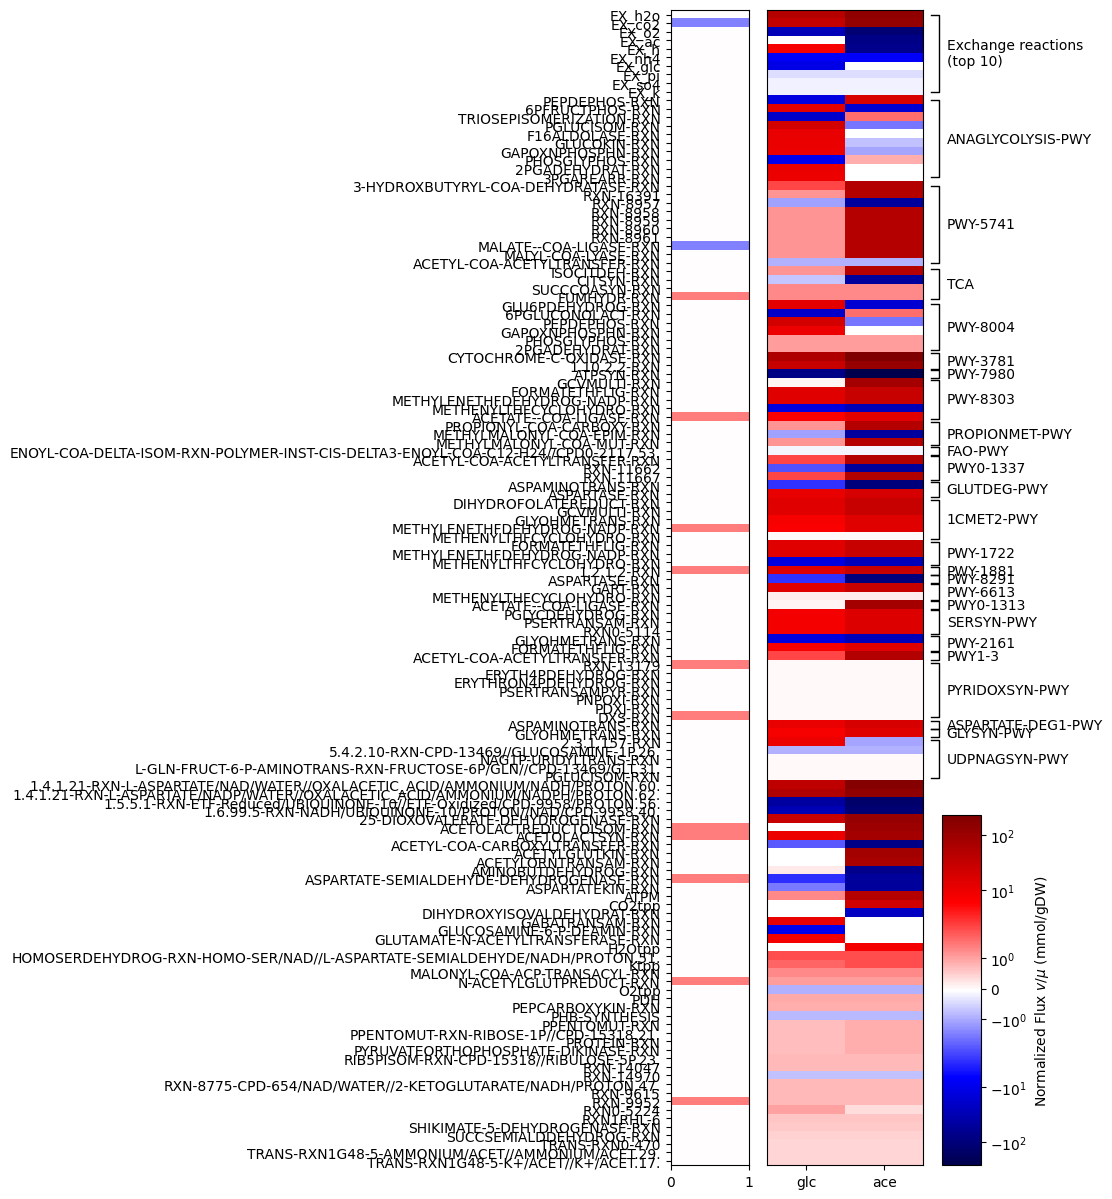

In [236]:
# Merge glc_fluxes and ace_fluxes into a dataframe
plot_fluxes = pd.DataFrame({"glc": glc_fluxes, "ace": ace_fluxes})

# Exclude biomass flux
plot_fluxes = plot_fluxes.drop("Rpom_hwa_biomass")

# Exclude external metabolite transport reactions (__tex), since
# their behavior is explained by the exchange reactions
# (Including periplasmic transport, __tpp, because periplasmic metabolites sometimes have unique reactions)
plot_fluxes = plot_fluxes[~plot_fluxes.index.str.endswith("tex")]

# Take absolute values, sort by flux difference, then by total flux, then by total absolute flux
# plot_fluxes = plot_fluxes.abs()
plot_fluxes["diff"] = np.abs(plot_fluxes["glc"] - plot_fluxes["ace"])
plot_fluxes["total"] = plot_fluxes["glc"] + plot_fluxes["ace"]
plot_fluxes["abs_total"] = np.abs(plot_fluxes["glc"]) + np.abs(plot_fluxes["ace"])
plot_fluxes = plot_fluxes.sort_values("diff", kind="stable")
plot_fluxes = plot_fluxes.sort_values("total", kind="stable")
plot_fluxes = plot_fluxes.sort_values("abs_total", kind="stable")
plot_fluxes = plot_fluxes.drop("diff", axis=1)
plot_fluxes = plot_fluxes.drop("total", axis=1)
plot_fluxes = plot_fluxes.drop("abs_total", axis=1)

# Filter reactions that always have zero flux, and set remaining zeros to NaN
plot_fluxes = plot_fluxes[(plot_fluxes != 0).any(axis=1)]
plot_fluxes = plot_fluxes.replace(0, np.nan)

# Get min and max values for color scaling
f_min = plot_fluxes.min().min()
f_max = plot_fluxes.max().max()

abs_co2_coeffs = [abs(get_co2_coeff(rxn)) for rxn in model.reactions]
c_max = max(abs_co2_coeffs)
c_min = -c_max

# Plot the fluxes!! =============================================================================================
OFFSET = 0.1
SHOW_RXN_NAMES = True
cmap="seismic"

# fig, (ax1, ax2) = plt.subplots(1, 3, sharey=True, gridspec_kw={"width_ratios": [1, 2]})
# fig, axs = plt.subplot_mosaic([["co2", "fluxes", "_"],
#                                ["co2", "fluxes", "cax"]],
#                             #    sharey=True,
#                                gridspec_kw={"width_ratios": [2, 4, 1], "height_ratios": [2, 1]})
# ax1 = axs["co2"]
# ax2 = axs["fluxes"]
# cax = axs["cax"]

fig = plt.figure()
gs = GridSpec(2, 3, figure=fig, width_ratios=[2, 4, 1], height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1], sharey=ax1)
cax = fig.add_subplot(gs[1, 2])

# Hide spacing axis
# axs["_"].axis("off")

# First, plot exchange reactions separately
pos = 0
yticks = []
plotted_reactions = set()

exchange_ids = [ex.id for ex in model.exchanges]
for rxn in reversed(plot_fluxes.index):
    if rxn not in exchange_ids:
        continue
    # Skip if flux is always < 0.01
    if plot_fluxes.loc[rxn].abs().max() < 0.01:
        continue
    
    # Plot CO2 coefficient
    ax1.imshow([[get_co2_coeff(model.reactions.get_by_id(rxn))]],
               cmap=cmap,
               aspect="auto",
               extent=(0, 1, pos, pos + 1),
               interpolation="none",
               vmin=c_min,
               vmax=c_max)

    # Plot fluxes
    ax2.imshow(plot_fluxes.loc[[rxn]],
                cmap=cmap,
                aspect="auto",
                extent=(0, 2, pos, pos + 1),
                interpolation="none",
                vmin=f_min,
                vmax=f_max,
                norm="symlog")
    yticks.append(rxn)
    plotted_reactions.add(rxn)
    pos += 1
vbracket(ax2, 2 + OFFSET, OFFSET, OFFSET, pos / 2, 0.9 * pos, text=f"Exchange reactions\n(top {pos})")

# First, plot fluxes from pathways of interest separately
for pathway in pathways_of_interest:
    
    # Pull out the reactions in the pathway
    rxns_in_pwy = []
    for rxn in plot_fluxes.index:
        pwys = model.reactions.get_by_id(rxn).annotation.get("pathways", [])
        if isinstance(pwys, str):
            pwys = [pwys]
        
        if pathway in pwys:
            rxns_in_pwy.append(rxn)

    # Plot CO2 coefficients
    ax1.imshow([[get_co2_coeff(model.reactions.get_by_id(rxn))] for rxn in rxns_in_pwy],
               cmap=cmap,
               aspect="auto",
               extent=(0, 1, pos, pos + len(rxns_in_pwy)),
               interpolation="none",
               vmin=c_min,
               vmax=c_max)
    
    # Plot the fluxes
    ax2.imshow(plot_fluxes.loc[rxns_in_pwy],
              cmap=cmap,
              aspect="auto",
              extent=(0, 2, pos, pos + len(rxns_in_pwy)),
              interpolation="none",
              vmin=f_min,
              vmax=f_max,
              norm="symlog")
    
    # Label the pathway
    vbracket(ax2, 2 + OFFSET, OFFSET, OFFSET, pos + len(rxns_in_pwy) / 2, 0.9 * len(rxns_in_pwy), text=pathway)

    pos += len(rxns_in_pwy)
    yticks.extend(rxns_in_pwy)
    plotted_reactions |= set(rxns_in_pwy)

# Filter the remaining to select top 100 fluxes,
# dropping the ones that have already been plotted
plot_fluxes = plot_fluxes[-100:]
plot_fluxes = plot_fluxes.drop(list(plotted_reactions), errors="ignore")
print(plot_fluxes.shape)

# Then, plot the rest

# Plot CO2 coefficients
ax1.imshow([[get_co2_coeff(model.reactions.get_by_id(rxn))] for rxn in plot_fluxes.index],
            cmap=cmap,
            aspect="auto",
            extent=(0, 1, pos, pos + len(plot_fluxes)),
            interpolation="none",
            vmin=c_min,
            vmax=c_max)

# Fluxes
mappable = ax2.imshow(plot_fluxes,
          cmap=cmap,
          aspect="auto",
          extent=(0, 2, pos, pos + len(plot_fluxes)),
          interpolation="none",
          vmin=f_min,
          vmax=f_max,
          norm="symlog")
yticks.extend(plot_fluxes.index.difference(plotted_reactions))

ax2.set_xticks([0.5, 1.5], ["glc", "ace"])
if SHOW_RXN_NAMES:
    ax1.set_yticks(0.5 + np.arange(len(yticks)), yticks)
    # turn off axis 2 ticks
    ax2.tick_params(axis="y", which="both", left=False, labelleft=False)
else:
    ax1.set_yticks([])
    ax2.set_yticks([])
ax2.set_ylim(0, pos + len(plot_fluxes))
ax2.invert_yaxis()

# Draw colorbar into cax
fig.colorbar(mappable, cax=cax, label="Normalized Flux $v/\\mu$ (mmol/gDW)")

fig.tight_layout()
fig.set_size_inches(4,15)

In [237]:
pathway

'UDPNAGSYN-PWY'

In [238]:
[rxn for rxn in model.reactions if "FAO-PWY" in rxn.annotation.get("pathways", [])]

[<Reaction ACYLCOADEHYDROG-RXN-POLYMER-INST-Saturated-Fatty-Acyl-CoA-C0-H0/ETF-Oxidized/PROTON//CROTONYL-COA/ETF-Reduced.90. at 0x7f989b5b7d40>,
 <Reaction ACYLCOADEHYDROG-RXN-POLYMER-INST-Saturated-Fatty-Acyl-CoA-C16-H32/ETF-Oxidized/PROTON//CPD-14928/ETF-Reduced.89. at 0x7f989b5b73b0>,
 <Reaction ACYLCOADEHYDROG-RXN-STEAROYL-COA/ETF-Oxidized/PROTON//POLYMER-INST-TRANS-D2-ENOYL-COA-C14-H28/ETF-Reduced.86. at 0x7f989b6554f0>,
 <Reaction ACYLCOASYN-RXN-POLYMER-INST-CPD66-39-C0-H0/CO-A/ATP//POLYMER-INST-Saturated-Fatty-Acyl-CoA-C0-H0/PPI/AMP.90. at 0x7f989b656cc0>,
 <Reaction ACYLCOASYN-RXN-POLYMER-INST-CPD66-39-C10-H20/CO-A/ATP//TETRADECANOYL-COA/PPI/AMP.66. at 0x7f989b654920>,
 <Reaction ACYLCOASYN-RXN-POLYMER-INST-CPD66-39-C16-H32/CO-A/ATP//POLYMER-INST-Saturated-Fatty-Acyl-CoA-C16-H32/PPI/AMP.94. at 0x7f989b654830>,
 <Reaction ACYLCOASYN-RXN-POLYMER-INST-CPD66-39-C2-H4/CO-A/ATP//HEXANOYL-COA/PPI/AMP.59. at 0x7f989b6557c0>,
 <Reaction ENOYL-COA-DELTA-ISOM-RXN-POLYMER-INST-CIS-DELTA3-E

In [239]:
glc_fluxes["PYRtex"]

0.0

In [240]:
model.metabolites.get_by_id("AMMONIUM[p]").reactions

frozenset({<Reaction NH4tex at 0x7f989ec303b0>,
           <Reaction RXN-9615 at 0x7f989a9d60f0>,
           <Reaction TRANS-RXN1G48-17-AMMONIUM/PROTON//AMMONIUM/PROTON.33. at 0x7f989aadcce0>,
           <Reaction TRANS-RXN1G48-5-AMMONIUM/ACET//AMMONIUM/ACET.29. at 0x7f989aa4c380>})

In [241]:
print(f"{model.reactions.get_by_id("EX_h")} glucose: {glc_fluxes["EX_h"]} \t acetate: {ace_fluxes["EX_h"]}")

EX_h: PROTON[e] <=>  glucose: 7.239471144520401 	 acetate: -68.72973315819308


In [242]:
print(f"{model.reactions.get_by_id("EX_nh4")} glucose: {glc_fluxes["EX_nh4"]} \t acetate: {ace_fluxes["EX_nh4"]}")
print(f"{model.reactions.get_by_id("NH4tex")} glucose: {glc_fluxes["NH4tex"]} \t acetate: {ace_fluxes["NH4tex"]}")

# print(f"{model.reactions.get_by_id("PYRtex")} glucose: {glc_fluxes["EX_pyr"]} \t acetate: {ace_fluxes["EX_pyr"]}")


EX_nh4: AMMONIUM[e] <=>  glucose: -7.41947302739428 	 acetate: -7.419473027388313
NH4tex: AMMONIUM[e] <=> AMMONIUM[p] glucose: 7.41947302739428 	 acetate: 7.419473027388313


In [243]:
for rxn in [rxn for rxn in model.reactions if "PYRUVDEHYD-PWY" in rxn.annotation.get("pathways", [])]:
    print(rxn)

In [244]:
model.reactions.get_by_id("PDH")

Reaction identifier,PDH
Name,Pyruvate dehydrogenase (NADH)
Memory address,0x7f989ab4dcd0
Stoichiometry,CO-A[c] + NAD[c] + PYRUVATE[c] --> ACETYL-COA[c] + CARBON-DIOXIDE[c] + NADH[c] coenzyme A + NAD+ + pyruvate --> acetyl-CoA + CO2 + NADH
GPR,
Lower bound,0.0
Upper bound,1000.0


In [245]:
model.reactions.get_by_id("6PFRUCTPHOS-RXN").annotation

# Should be in glycolysis - why is it missing?

{'EC Number': '2.7.1.11',
 'Kegg ID': 'R00756',
 'stem': '6PFRUCTPHOS-RXN',
 'pathways': 'ANAGLYCOLYSIS-PWY'}

In [246]:
# Sort pathways by total flux
pathway_fluxes = {}
for rxn in plot_fluxes.index:
    pwys = model.reactions.get_by_id(rxn).annotation.get("pathways", [])
    if isinstance(pwys, str):
        pwys = [pwys]

    for pwy in pwys:
        if pwy not in pathway_fluxes:
            pathway_fluxes[pwy] = 0
        pathway_fluxes[pwy] += plot_fluxes.loc[rxn].sum()

df = pd.DataFrame({"flux": pathway_fluxes})
df.sort_values("flux", ascending=False).head(50)

,flux
GLUCONEO-PWY,94.887046
ARGSYNBSUB-PWY,6.121803
GLUTORN-PWY,4.591352
ARGSYN-PWY,4.591352
BRANCHED-CHAIN-AA-SYN-PWY,4.359495
VALSYN-PWY,4.359495
PWY-4381,3.614728
OXIDATIVEPENT-PWY,2.122850
PWY-6163,1.310211
PWY-6630,1.310211


In [247]:
PWY-3781  # aerobic respiration I (cytochrome c)
PWY-5741  # Ethylmalonyl-CoA pathway
PWY-7980  # ATP biosynthesis
PWY-8303  # reductive glycine pathway of autotrophic CO2 fixation
ANAGLYCOLYSIS-PWY  # Glycolysis
PROPIONMET-PWY  # propanoyl CoA degradation I
FAO-PWY  # fatty acid β-oxidation I (generic)
PWY0-1337  # oleate β-oxidation
GLUTDEG-PWY  # L-glutamate degradation II
1CMET2-PWY	# folate transformations III (E. coli)
PWY-1722  # formate assimilation into 5,10-methylenetetrahydrofolate
PWY-8004  # Entner-Doudoroff pathway I
PWY-1881  # formate oxidation to CO2
TCA
PWY-8291  # L-aspartate degradation II (aerobic)
PWY-6613  # tetrahydrofolate salvage from 5,10-methenyltetrahydrofolate
PWY0-1313  # acetate conversion to acetyl-CoA
PWY-8279  # palmitate biosynthesis III
PWY-8280  # stearate biosynthesis IV  (likely dupe of above)
PWY-7388  # octanoyl-[acyl-carrier protein] biosynthesis (mitochondria, yeast)
FASYN-ELONG-PWY  # fatty acid elongation -- saturated
SERSYN-PWY  # L-serine biosynthesis I
PWY-2161  # folate polyglutamylation
PWY1-3  # polyhydroxybutanoate biosynthesis
PYRIDOXSYN-PWY  # pyridoxal 5'-phosphate biosynthesis I
PHESYN  # L-phenylalanine biosynthesis I
TYRSYN  # L-tyrosine biosynthesis I
ASPARTATE-DEG1-PWY  # L-aspartate degradation I
PWY-6638  # sulfolactate degradation III
PWY-5329  # L-cysteine degradation III
PWY-5886  # 3-(4-hydroxyphenyl)pyruvate biosynthesis
GLYSYN-PWY  # glycine biosynthesis I
UDPNAGSYN-PWY  # UDP-N-acetyl-D-glucosamine biosynthesis I

# All below probably identical
PWY-5971  # palmitate biosynthesis II (type II fatty acid synthase)
PWY-6282  # palmitoleate biosynthesis I (from (5Z)-dodec-5-enoate)
PWY0-862   # (5Z)-dodecenoate biosynthesis I 
PWY-7664  # oleate biosynthesis IV (anaerobic)
PWY-7663  # gondoa biosynthesis (anaerobic)
PWY-8203  # 8-amino-7-oxononanoate biosynthesis IV 	
PWY-6163  # chorismate biosynthesis from 3-dehydroquinate

# Probably RXN0-5055?
PWY-4381  # fatty acid biosynthesis initiation (type II)
PWY0-1264  # biotin-carboxyl carrier protein assembly

SyntaxError: invalid decimal literal (265365928.py, line 10)

In [ ]:
model.reactions.get_by_id("GLYOHMETRANS-RXN")

Reaction identifier,GLYOHMETRANS-RXN
Name,GLYOHMETRANS-RXN
Memory address,0x7f867cc3fa40
Stoichiometry,"SER[c] + THF-GLU-N[c] <=> GLY[c] + METHYLENE-THF-GLU-N[c] + WATER[c] L-serine + a tetrahydrofolate <=> glycine + a 5,10-methylenetetrahydrofolate + H2O"
GPR,G1G48-3584 or G1G48-1604 or G1G48-2988
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
plot_fluxes.loc["GLYOHMETRANS-RXN"]

glc     5.846592
ace    14.333070
Name: GLYOHMETRANS-RXN, dtype: float64